In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Shape: (60000, 28, 28, 1)
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Sampling function using reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 2

# encoder model
encoder_inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# VAE model combining encoder and decoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # Logging losses
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)


In [ ]:
# Compile the VAE
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE
vae.fit(x_train, epochs=30, batch_size=128)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - kl_loss: 2.1901 - loss: 220.4833 - reconstruction_loss: 218.2932
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.2232 - loss: 192.3389 - reconstruction_loss: 189.1157
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 3.2880 - loss: 187.7572 - reconstruction_loss: 184.4692
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.3651 - loss: 185.1013 - reconstruction_loss: 181.7362
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - kl_loss: 3.3865 - loss: 183.5207 - reconstruction_loss: 180.1342
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.4253 - loss: 182.1268 - reconstruction_loss: 178.7014
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.5077 - loss: 180.6944 - reconstruction_loss: 177.1867
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.5853 - loss: 179.5212 - reconstruction_loss: 175.9360
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

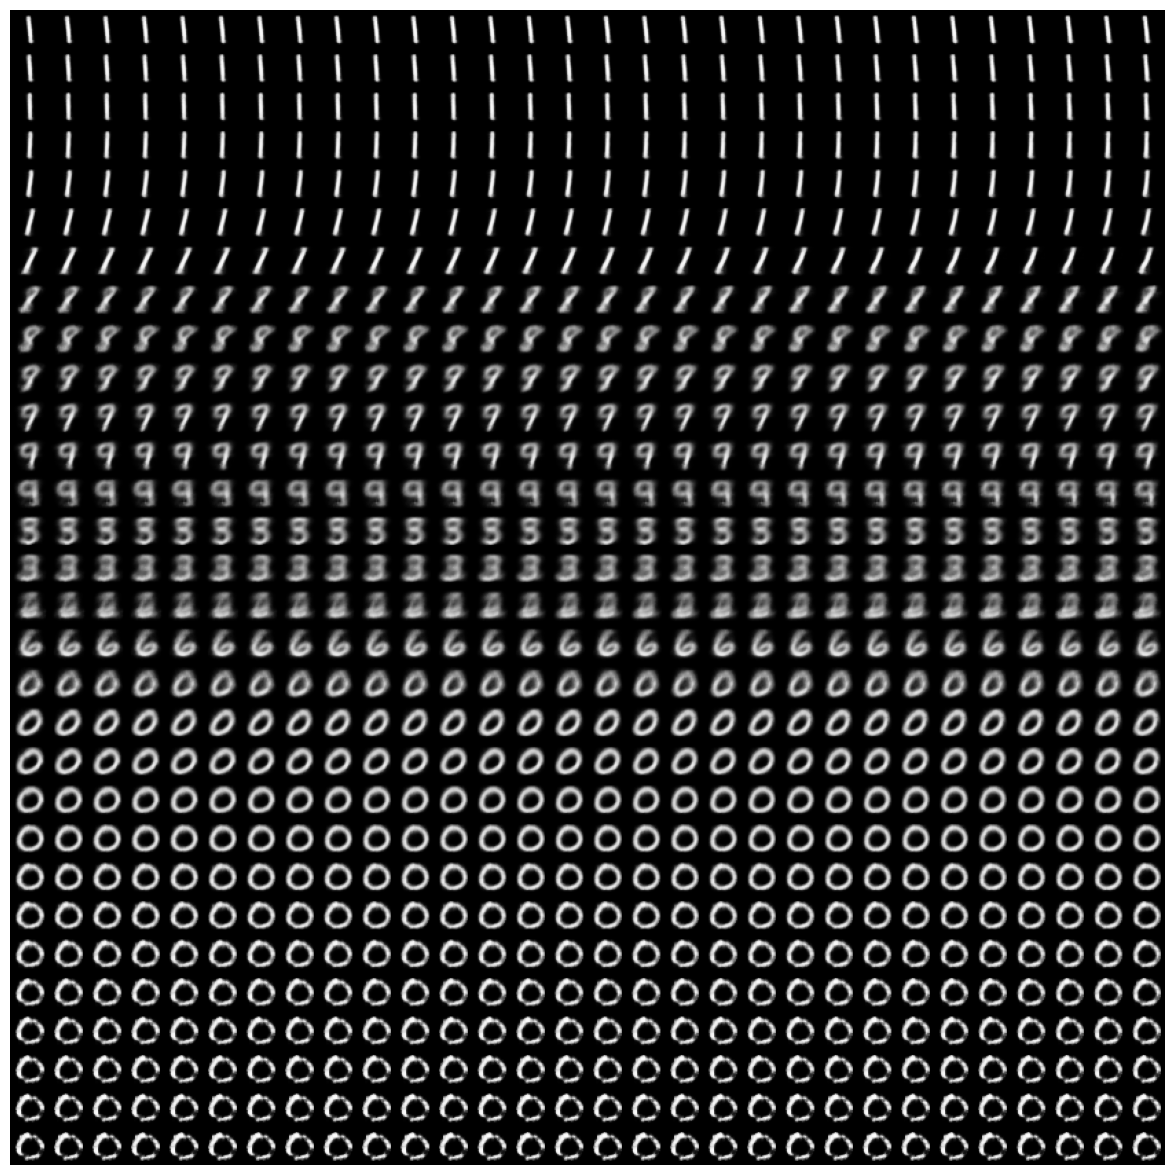

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 3.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.axis('Off')
    plt.show()

# Plot the 2D manifold of digits
plot_latent_space(vae)


In [ ]:
# Select random images from the test set
num_images = 10
random_idx = np.random.choice(len(x_test), num_images)
test_images = x_test[random_idx]

# Reconstruct the images
z_mean, z_log_var, z = vae.encoder.predict(test_images)
reconstructed_images = vae.decoder.predict(z)

# Plot the original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Original images
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()
